In [1]:
import cv2
import itertools, os, time
import numpy as np
from Model import get_Model
from parameter import letters
import argparse
from keras import backend as K
import matplotlib.pyplot as plt
from glob import glob
K.set_learning_phase(0)

Using TensorFlow backend.
c:\users\enos\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\enos\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\enos\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
def decode_label(out):
    # out : (1, 32, 42)
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

In [54]:
def predict(weight, pred_path, plot=True, v=True, keep_ratio=False):
    
    # Get CRNN model
    model = get_Model(training=False)

    try:
        if v:
            print(f'Model {weight} ...')
        model.load_weights(weight)
    except:
        raise Exception("No weight file!")

    test_dirs = [p for p in pred_path] if isinstance(pred_path, list) else [pred_path]
    results = []
    for t in test_dirs:
        if v:
            print(f'Prediction {t}', end=' ')
        files = glob(os.path.join(t, '*.[jp][pn]g'))
        if v:
            print(f'{len(files)} images', end=' ')
        r = model_predict_files(model, files, plot, v, keep_ratio)
        if v:
            print(f'ACC: {r[1]:.3f}; CHAR_ACC: {r[2]:.3f}; CHAR_RECALL: {r[3]:.3f}; CHAR_PRECISION: {r[4]:.3f} elapsed {r[0]:.2f}s')
        r.insert(0, t)
        results.append(r)
        
    return results

def model_predict_files(model, files, plot=True, v=True, keep_ratio=False):
    
    start = time.time()
    total = len(files)
    acc = 0
    letter_total = 0
    char_rttl = 0
    char_pttl = 0
    letter_acc = 0
    ans = []
    for f in files:
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if keep_ratio:
            img = keepratio(img)
        img = cv2.resize(img, (128, 64))
        im = (img / 255.0) * 2.0 - 1.0
        im = im.T
        im = np.expand_dims(im, axis=-1)
        im = np.expand_dims(im, axis=0)

        net_out_value = model.predict(im)
        pred_texts = decode_label(net_out_value) # enos should check this
        y = os.path.splitext(os.path.split(f)[-1])[0]
        
        #should check this comparsion algorithm
        a, ca = score(y, pred_texts)
        acc += a
        letter_acc += ca
        letter_total += max(len(pred_texts), len(y))
        char_rttl += len(y)
        char_pttl += len(pred_texts)
        ans.append([img, y, pred_texts])
    
    acc = acc / total
    cacc = letter_acc / letter_total
    cracc = letter_acc / char_rttl
    cpacc = letter_acc / char_pttl
    s = time.time() - start
    
    if v:
        print(f'ACC: {acc:.3f}; CHAR_ACC: {cacc:.3f}; CHAR_RECALL: {cracc:.3f}; CHAR_PRECISION: {cpacc:.3f} elapsed {s:.2f}s')
    
    if plot:
        plot_plate(ans)
        
    return [s, acc, cacc, cracc, cpacc]

def score(t, p):
    acc = 0
    char_rttl = len(t) #recall, based on truth
    char_pttl = len(p) #precision, based on prediction
    
    if t == p:
        acc += 1
        char_acc = len(t)
    else:
        ps = p.split('-')
        if len(ps)<=1 or len(ps)>=3 : #no sep or too many sep, 傳統比對
            char_acc = cmp(t, p)
        else: #只有一個 sep
            char_acc = 1 #for sep
            ts = t.split('-')
            char_acc += cmp(ts[0], ps[0])
            char_acc += cmp(ts[1], ps[1])
        
    return acc, char_acc
            
def cmp(t, p):
    char_acc = 0
    if len(t) == len(p): #字數相同
        for x,y in zip(t,p):
            if x == y:
                char_acc += 1
    else: #字數不同
        acc1 = 0
        acc2 = 0        
        for i in range(min(len(p), len(t))):
            if p[i] == t[i]:
                acc1 += 1
        for i in range(-1, -min(len(p), len(t))-1, -1):
            if p[i] == t[i]:
                acc2 += 1
        char_acc = max(acc1, acc2)
    
    return char_acc

def models_predict(models, predicts, keep_ratio=False):
    for model in models:
        print(f'{model}')
        results = predict(model, predicts, plot=False, v=False, keep_ratio=keep_ratio) # path, secs, acc, char_acc
        for i, r in enumerate(results):
            print(f'{r[0]} => ACC: {r[2]:.3f}; CHAR_ACC: {r[3]:.3f}; CHAR_RECALL: {r[4]:.3f}; CHAR_PRECISION: {r[5]:.3f} elapsed {r[1]:.2f}s')

def plot_plate(ans):
    width = 5
    height = len(ans) // width + 1# // 取商
    plt.figure(figsize=(20,10))
    for i,a in enumerate(ans):
        plt.subplot(height, width, i+1)
        t = f'[T]{a[1]}\n[P]{a[2]}'
        plt.title(t, fontproperties='SimSun', fontsize=20)
        plt.axis('off')
        plt.imshow(a[0], cmap='gray')
    plt.show()

In [4]:
models = ['model/legacy/lpr34-220-1.126.hdf5',
          'model/wcp_0407_random+ep90+ep90-79-0.833.hdf5']
predicts = ['../real_plate/', '../real_plate_4/', './test']
models_predict(models, predicts)

model/legacy/lpr34-220-1.126.hdf5
Instructions for updating:
Colocations handled automatically by placer.
../real_plate/ => ACC: 0.100; CHAR_ACC: 0.563; CHAR_RECALL: 0.628; CHAR_PRECISION: 0.590 elapsed 2.47s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.818; CHAR_RECALL: 0.900; CHAR_PRECISION: 0.818 elapsed 0.49s
./test => ACC: 0.203; CHAR_ACC: 0.652; CHAR_RECALL: 0.687; CHAR_PRECISION: 0.688 elapsed 143.21s
model/wcp_0407_random+ep90+ep90-79-0.833.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.628; CHAR_RECALL: 0.628; CHAR_PRECISION: 0.671 elapsed 0.85s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.857; CHAR_RECALL: 0.900; CHAR_PRECISION: 0.878 elapsed 0.49s
./test => ACC: 0.354; CHAR_ACC: 0.762; CHAR_RECALL: 0.775; CHAR_PRECISION: 0.813 elapsed 141.23s


In [285]:
models = ['model/legacy/lpr34-220-1.126.hdf5',
          'model/wcp_0407_random+ep90+ep90-79-0.833.hdf5']
predicts = ['../real_plate/', '../real_plate_4/', './test']
models_predict(models, predicts)

model/legacy/lpr34-220-1.126.hdf5
../real_plate/ => ACC: 0.100; CHAR_ACC: 0.563; CHAR_RECALL: 0.628; CHAR_PRECISION: 0.590 elapsed 21.83s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.818; CHAR_RECALL: 0.900; CHAR_PRECISION: 0.818 elapsed 0.67s
./test => ACC: 0.606; CHAR_ACC: 0.907; CHAR_RECALL: 0.921; CHAR_PRECISION: 0.917 elapsed 195.23s
model/wcp_0407_random+ep90+ep90-79-0.833.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.628; CHAR_RECALL: 0.628; CHAR_PRECISION: 0.671 elapsed 22.07s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.857; CHAR_RECALL: 0.900; CHAR_PRECISION: 0.878 elapsed 0.70s
./test => ACC: 0.826; CHAR_ACC: 0.969; CHAR_RECALL: 0.970; CHAR_PRECISION: 0.981 elapsed 203.88s


In [24]:
models = ['model/wcp_0410-17-2.537.hdf5']
predicts = ['../real_plate/', '../real_plate_4/', 'test']
models_predict(models, predicts)

model/wcp_0410-17-2.537.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.716 elapsed 6.45s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.938; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.950 elapsed 0.56s
test => ACC: 0.603; CHAR_ACC: 0.900; CHAR_RECALL: 0.905; CHAR_PRECISION: 0.928 elapsed 170.55s


In [26]:
models = ['model/wcp_0410-17-2.537.hdf5',
          'model/wcp_0410-19-2.379.hdf5',
          'model/wcp_0410-20-2.276.hdf5',
          'model/wcp_0410-23-2.190.hdf5',
          'model/wcp_0410-24-2.320.hdf5',
          'model/wcp_0410-25-2.175.hdf5',
          'model/wcp_0410-26-2.082.hdf5',
          'model/wcp_0410-27-2.191.hdf5',
          'model/wcp_0410-32-1.902.hdf5',
          'model/wcp_0410-34-1.960.hdf5']
predicts = ['../real_plate/', '../real_plate_4/']
models_predict(models, predicts)

model/wcp_0410-17-2.537.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.716 elapsed 7.51s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.938; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.950 elapsed 0.57s
model/wcp_0410-19-2.379.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.703 elapsed 7.24s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.939; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.951 elapsed 0.59s
model/wcp_0410-20-2.276.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.707 elapsed 8.40s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.927; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.938 elapsed 0.57s
model/wcp_0410-23-2.190.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.707 elapsed 8.00s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.927; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.938 elapsed 0.78s
model/wcp_0410-24-2.320.hdf5
../real_plate/ => ACC: 

Model model/wcp_0410-25-2.175.hdf5 ...
Prediction ../real_plate/ 10 images ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.716 elapsed 1.80s


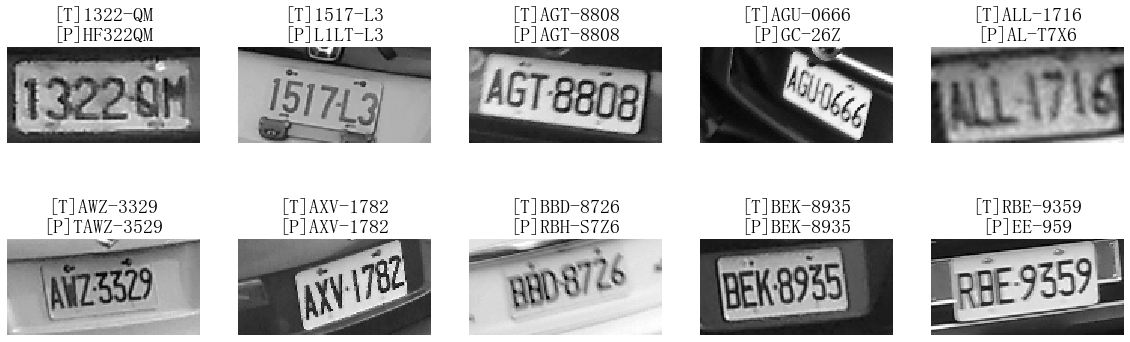

ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.716 elapsed 1.80s


[['../real_plate/',
  1.7985200881958008,
  0.3,
  0.6708860759493671,
  0.6794871794871795,
  0.7162162162162162]]

In [12]:
predict('model/wcp_0410-25-2.175.hdf5', '../real_plate/')

Model model/wcp_0410-20-2.276.hdf5 ...
Prediction ../real_plate/ 10 images ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.707 elapsed 1.92s


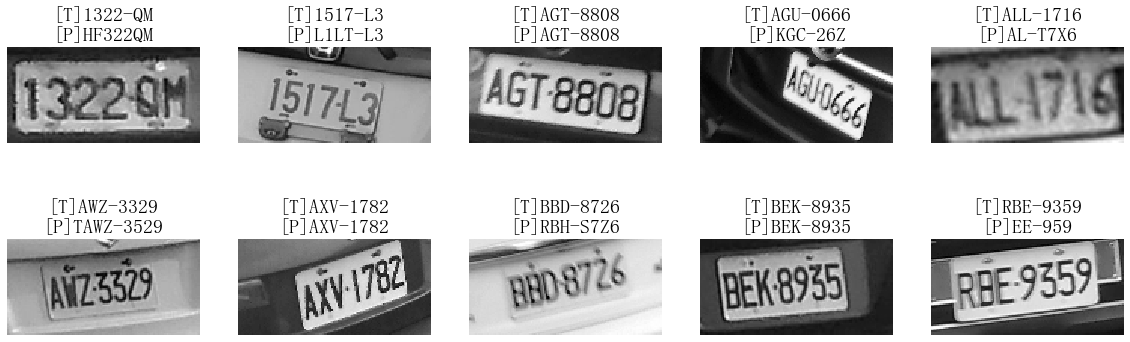

ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.707 elapsed 1.92s


[['../real_plate/',
  1.9220943450927734,
  0.3,
  0.6708860759493671,
  0.6794871794871795,
  0.7066666666666667]]

In [13]:
predict('model/wcp_0410-20-2.276.hdf5', '../real_plate/')

In [23]:
models = ['model/wcp_0410-15-2.623.hdf5',
          'model/wcp_0410-16-2.419.hdf5',
          'model/wcp_0410-17-2.537.hdf5',
          'model/wcp_0410-18-2.418.hdf5',
          'model/wcp_0410-19-2.379.hdf5']
predicts = ['../real_plate/', '../real_plate_4/']
models_predict(models, predicts)

model/wcp_0410-15-2.623.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.646; CHAR_RECALL: 0.654; CHAR_PRECISION: 0.689 elapsed 6.03s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.60s
model/wcp_0410-16-2.419.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.625; CHAR_RECALL: 0.641; CHAR_PRECISION: 0.658 elapsed 5.94s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.56s
model/wcp_0410-17-2.537.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.671; CHAR_RECALL: 0.679; CHAR_PRECISION: 0.716 elapsed 5.64s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.938; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.950 elapsed 0.56s
model/wcp_0410-18-2.418.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.703 elapsed 6.44s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.938; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.950 elapsed 0.58s
model/wcp_0410-19-2.379.hdf5
../real_plate/ => ACC: 

In [25]:
models = ['model/wcp_0410-13-2.624.hdf5',
          'model/wcp_0410-14-2.621.hdf5',
          'model/wcp_0410-33-2.012.hdf5',
          'model/wcp_0410-34-1.960.hdf5']
predicts = ['../real_plate/', '../real_plate_4/']
models_predict(models, predicts)

model/wcp_0410-13-2.624.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.625; CHAR_RECALL: 0.641; CHAR_PRECISION: 0.676 elapsed 6.28s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.56s
model/wcp_0410-14-2.621.hdf5
../real_plate/ => ACC: 0.200; CHAR_ACC: 0.625; CHAR_RECALL: 0.641; CHAR_PRECISION: 0.676 elapsed 6.46s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.57s
model/wcp_0410-33-2.012.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.693 elapsed 6.88s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.902; CHAR_RECALL: 0.925; CHAR_PRECISION: 0.925 elapsed 0.57s
model/wcp_0410-34-1.960.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.667; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.712 elapsed 6.80s
../real_plate_4/ => ACC: 0.600; CHAR_ACC: 0.938; CHAR_RECALL: 0.950; CHAR_PRECISION: 0.950 elapsed 0.56s


In [27]:
models = ['model/wcp_0410-10-2.833.hdf5',
          'model/wcp_0410-11-2.770.hdf5',
          'model/wcp_0410-12-2.692.hdf5',
          'model/wcp_0410-35-1.878.hdf5',
          'model/wcp_0410-36-1.903.hdf5']
predicts = ['../real_plate/', '../real_plate_4/']
models_predict(models, predicts)

model/wcp_0410-10-2.833.hdf5
../real_plate/ => ACC: 0.100; CHAR_ACC: 0.608; CHAR_RECALL: 0.615; CHAR_PRECISION: 0.667 elapsed 12.06s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.77s
model/wcp_0410-11-2.770.hdf5
../real_plate/ => ACC: 0.100; CHAR_ACC: 0.588; CHAR_RECALL: 0.603; CHAR_PRECISION: 0.635 elapsed 9.75s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.75s
model/wcp_0410-12-2.692.hdf5
../real_plate/ => ACC: 0.100; CHAR_ACC: 0.600; CHAR_RECALL: 0.615; CHAR_PRECISION: 0.649 elapsed 9.83s
../real_plate_4/ => ACC: 0.700; CHAR_ACC: 0.951; CHAR_RECALL: 0.963; CHAR_PRECISION: 0.963 elapsed 0.60s
model/wcp_0410-35-1.878.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.703 elapsed 11.23s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.914; CHAR_RECALL: 0.925; CHAR_PRECISION: 0.949 elapsed 0.60s
model/wcp_0410-36-1.903.hdf5
../real_plate/ => ACC

In [28]:
models = ['model/wcp_0410-37-1.883.hdf5',
          'model/wcp_0410-38-1.854.hdf5']
predicts = ['../real_plate/', '../real_plate_4/']
models_predict(models, predicts)

model/wcp_0410-37-1.883.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.693 elapsed 9.53s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.902; CHAR_RECALL: 0.925; CHAR_PRECISION: 0.925 elapsed 0.59s
model/wcp_0410-38-1.854.hdf5
../real_plate/ => ACC: 0.300; CHAR_ACC: 0.658; CHAR_RECALL: 0.667; CHAR_PRECISION: 0.693 elapsed 9.76s
../real_plate_4/ => ACC: 0.500; CHAR_ACC: 0.914; CHAR_RECALL: 0.925; CHAR_PRECISION: 0.949 elapsed 0.60s


In [4]:
models = ['model/wcp_0410-17-2.537.hdf5']
predicts = ['../real_plate_5/', '../real_plate_6/']
models_predict(models, predicts)

model/wcp_0410-17-2.537.hdf5
Instructions for updating:
Colocations handled automatically by placer.
../real_plate_5/ => ACC: 0.667; CHAR_ACC: 0.958; CHAR_RECALL: 0.958; CHAR_PRECISION: 0.958 elapsed 1.53s
../real_plate_6/ => ACC: 0.333; CHAR_ACC: 0.708; CHAR_RECALL: 0.708; CHAR_PRECISION: 0.708 elapsed 0.15s


In [71]:
models = ['model/wcp_0410-17-2.537.hdf5']
predicts = ['../real_plate_6/']
models_predict(models, predicts, keep_ratio=True)

model/wcp_0410-17-2.537.hdf5
(238, 332) h2>w (238, 476)
(171, 347) h2<w (173, 347)
(180, 230) h2>w (180, 360)
../real_plate_6/ => ACC: 0.000; CHAR_ACC: 0.346; CHAR_RECALL: 0.375; CHAR_PRECISION: 0.346 elapsed 1.69s


Model model/wcp_0410-17-2.537.hdf5 ...
Prediction ../real_plate_5/ 3 images ACC: 0.667; CHAR_ACC: 0.958; CHAR_RECALL: 0.958; CHAR_PRECISION: 0.958 elapsed 2.03s


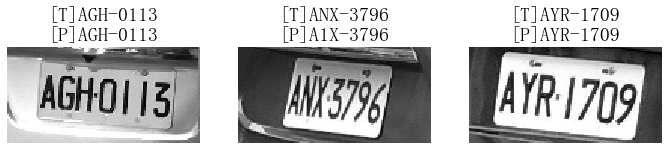

ACC: 0.667; CHAR_ACC: 0.958; CHAR_RECALL: 0.958; CHAR_PRECISION: 0.958 elapsed 2.03s


[['../real_plate_5/',
  2.032566547393799,
  0.6666666666666666,
  0.9583333333333334,
  0.9583333333333334,
  0.9583333333333334]]

In [75]:
predict('model/wcp_0410-17-2.537.hdf5', '../real_plate_5/')

Model model/wcp_0410-17-2.537.hdf5 ...
Prediction ../real_plate_6/ 3 images ACC: 0.333; CHAR_ACC: 0.708; CHAR_RECALL: 0.708; CHAR_PRECISION: 0.708 elapsed 2.21s


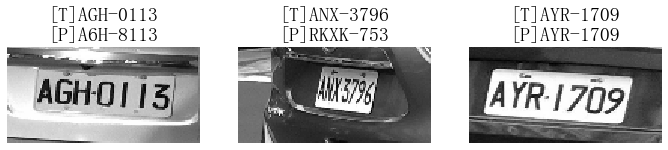

ACC: 0.333; CHAR_ACC: 0.708; CHAR_RECALL: 0.708; CHAR_PRECISION: 0.708 elapsed 2.21s


[['../real_plate_6/',
  2.211088180541992,
  0.3333333333333333,
  0.7083333333333334,
  0.7083333333333334,
  0.7083333333333334]]

In [76]:
predict('model/wcp_0410-17-2.537.hdf5', '../real_plate_6/')

Model model/wcp_0410-17-2.537.hdf5 ...
Prediction ../real_plate_5/ 3 images ACC: 0.667; CHAR_ACC: 0.958; CHAR_RECALL: 0.958; CHAR_PRECISION: 0.958 elapsed 0.52s


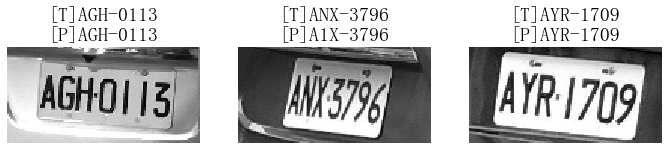

ACC: 0.667; CHAR_ACC: 0.958; CHAR_RECALL: 0.958; CHAR_PRECISION: 0.958 elapsed 0.52s


[['../real_plate_5/',
  0.5226035118103027,
  0.6666666666666666,
  0.9583333333333334,
  0.9583333333333334,
  0.9583333333333334]]

In [6]:
predict('model/wcp_0410-17-2.537.hdf5', '../real_plate_5/')

Model model/wcp_0410-17-2.537.hdf5 ...
Prediction ../real_plate_6/ 3 images ACC: 0.333; CHAR_ACC: 0.708; CHAR_RECALL: 0.708; CHAR_PRECISION: 0.708 elapsed 0.67s


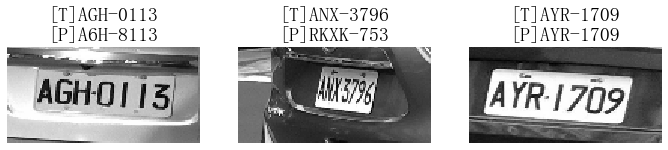

ACC: 0.333; CHAR_ACC: 0.708; CHAR_RECALL: 0.708; CHAR_PRECISION: 0.708 elapsed 0.67s


[['../real_plate_6/',
  0.6653242111206055,
  0.3333333333333333,
  0.7083333333333334,
  0.7083333333333334,
  0.7083333333333334]]

In [37]:
predict('model/wcp_0410-17-2.537.hdf5', '../real_plate_6/')

In [69]:
def keepratio(img):
    #h, w, c = img.shape
    h = img.shape[0]
    w = img.shape[1]
    h2 = h * 2
    print(img.shape, end=' ')
    
    if h2 == w:
        print('same')
        return img.copy()
    
    if h2 > w:
        fh = h
        fw = h2
        dw = int((fw-w)/2)
        if len(img.shape) == 3:
            f = np.zeros((fh, fw, img.shape[2]), dtype=np.uint8)
        else:
            f = np.zeros((fh, fw), dtype=np.uint8)
        print('h2>w', f.shape)
        f[:, dw:w+dw] = img
    else: # h2 < w
        fh = int(w/2)
        fw = w
        dh = int((fh-h)/2)
        if len(img.shape) == 3:
            f = np.zeros((fh, fw, img.shape[2]), dtype=np.uint8)
        else:
            f = np.zeros((fh, fw), dtype=np.uint8)
        print('h2<w', f.shape)
        f[dh:h+dh, :] = img
    
    return f

(238, 332, 3)
(238, 476, 3)


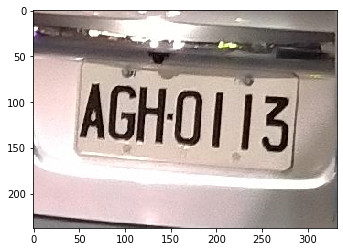

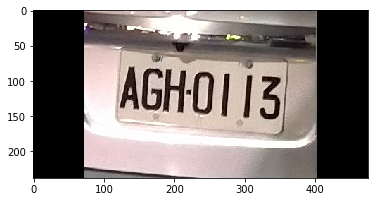

In [34]:
a = cv2.imread('../real_plate_6/AGH-0113.jpg', )
x = keep_ratio(a)
plt.imshow(a)
plt.show()
plt.imshow(x)
plt.show()

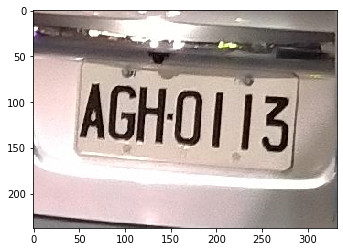

In [43]:
a = cv2.imread('../real_plate_6/AGH-0113.jpg', )
plt.imshow(a)

In [50]:
type(a.copy())

numpy.ndarray

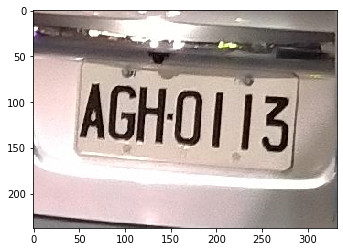

In [48]:
plt.imshow(x)